In [1]:
# USE DESI env 19.2 instead 
# so we may use ! pip install --user pydl 

In [2]:
import os
import time 
import h5py 
import numpy as np 
from astropy.io import fits 
from pydl.pydlutils.spheregroup import spherematch
# plotting 
#import matplotlib as mpl
#mpl.use('agg')
import matplotlib.pyplot as plt 
%matplotlib inline

### ANALISIS OVERLAP DR9d

In [5]:
#no need to rerun this go below
f_decals = fits.open(os.path.join('/global/cfs/projectdirs/cosmo/work/legacysurvey/dr9d/south/sweep', 
                'sweep-130p030-140p035.fits')) 
decals = f_decals[1].data 
print('%i decals objects' % len(decals['ra']))
    
# read in prime sweep
f_prime = fits.open(os.path.join('//global/cfs/projectdirs/cosmo/work/legacysurvey/dr9d/north/sweep', 
                'sweep-130p030-140p035.fits'))
prime = f_prime[1].data 
print('%i prime objects' % len(prime['ra']))

1563997 decals objects
1076147 prime objects


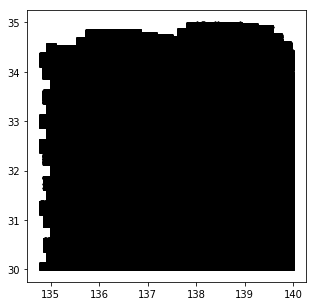

In [7]:
# no need to rerun this, go below
# plot of the selected sweep without cuts
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(decals['ra'], decals['dec'], c='k', s=2) 

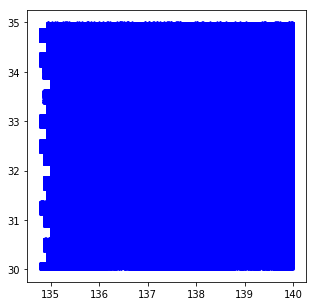

In [8]:
# no need to rerun this, go below
# plot of the selected sweep without cuts
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(prime['ra'], prime['dec'], c='b', s=2) 

In [10]:
#no need to rerun this, go below
print("From the plot above I choose cuts: (135.2 <ra <140.0, 30.0 dec < 34.1)") 

From the plot above I choose cuts: (135.2 <ra <140.0, 30.0 dec < 34.1)


In [11]:
# no need to rerun this go below
# get indices for cut-zone
decals_radec_cut = (decals['ra'] > 135.2) & (decals['ra'] < 140.0) & (decals['dec'] > 30.0)  & (decals['dec'] < 34.1) 
prime_radec_cut = (prime['ra'] > 135.2) & (prime['ra'] < 140.) & (prime['dec'] > 30.0)  & (prime['dec'] < 34.1) 
print('%i decals objects within cut' % np.sum(decals_radec_cut))
print('%i prime objects within cut' % np.sum(prime_radec_cut)) 

1302296 decals objects within cut
790739 prime objects within cut


Text(0,0.5,'Dec')

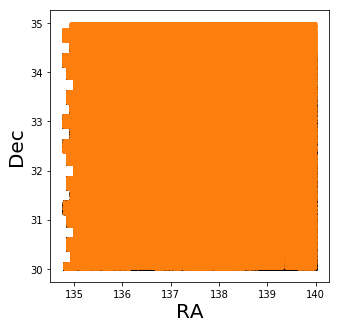

In [12]:
# no need to rerun this, go below
# plot of the selected sweep without cuts
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(decals['ra'], decals['dec'], c='k', s=2) 
sub.scatter(prime['ra'], prime['dec'], c='C1', s=1) 
sub.set_xlabel('RA', fontsize=20) 
sub.set_ylabel('Dec', fontsize=20) 
#sub.set_xlim(135.8, 137.2) 
#sub.set_ylim(31.8, 33.2) 

In [ ]:
# match no need to redo
t0 = time.time() 
# now lets spherematch 
m_decals, m_prime, d_match = spherematch(
    decals['ra'][decals_radec_cut], decals['dec'][decals_radec_cut], 
    prime['ra'][prime_radec_cut], prime['dec'][prime_radec_cut], 
    0.0005, # match lenght roughly 1.5 arcsec
    maxmatch=1) 
print('spehrematch takes', time.time() - t0) 
print('%i out of %i decals objects have match' % (len(m_decals), np.sum(decals_radec_cut)))
print('%i out of %i prime objects have match' % (len(m_prime), np.sum(prime_radec_cut)))
pathdir = '/global/project/projectdirs/desi/users/manera/'
np.save(pathdir+'decals_match-dr9d.npy', m_decals)
np.save(pathdir+'prime_match-dr9d.npy', m_prime)

In [15]:
m_decals

array([208471, 614781, 614763, ..., 699099, 319087, 212367], dtype=int32)

In [16]:
pathdir = '/global/project/projectdirs/desi/users/manera/'
filename = pathdir + 'decals_match-dr9d.npy'
m_decals = np.load(filename)
filename = pathdir + 'prime_match-dr9d.npy'
m_prime = np.load(filename)

In [17]:
# decals.names gives the list of fields in decals 
# remove from the decals list the fields that are strings 

listdecals = np.ones(len(decals.names))
for i in range(len(decals.names)):
    a = type(decals[decals.names[i]][1])
    if( a == type(str()) ): listdecals[i]=0    

listprime = np.ones(len(prime.names))
for i in range(len(prime.names)):
    a = type(prime[prime.names[i]][1])
    if( a == type(str()) ): listprime[i]=0   

In [19]:
# save joint dataset
pathdir = '/global/project/projectdirs/desi/users/manera/'
f = h5py.File(pathdir+'decals_prime.radeccut_dr9c.hdf5', 'w') 
# save all non string decals columns
grp = f.create_group('decals') 
for i, k in enumerate(decals.names): 
    if( listdecals[i] ) :
        if len(decals[k]) == len(decals['ra']):  
            grp.create_dataset(str(k), data=decals[k][decals_radec_cut][m_decals]) 
    else:
         if len(decals[k]) == len(decals['ra']):
            aux = decals[k][decals_radec_cut][m_decals]
            asciiList = [n.encode("ascii", "ignore") for n in aux]
            grp.create_dataset(str(k),  data=asciiList, dtype='S4',) 
            #grp.create_dataset(str(k), (len(asciiList),1), dtype='S4', data=asciiList) 
        
# save all non string prime columns
grp = f.create_group('prime') 
for i, k in enumerate(prime.names):
    if (listprime[i]):
        if len(prime[k]) == len(prime['ra']):  
            grp.create_dataset(str(k), data=prime[k][prime_radec_cut][m_prime]) 
    else:
        if len(decals[k]) == len(decals['ra']):
            aux = prime[k][prime_radec_cut][m_prime]
            asciiList = [n.encode("ascii", "ignore") for n in aux]
            grp.create_dataset(str(k),  data=asciiList, dtype='S4',) 
            #grp.create_dataset(str(k), (len(asciiList),1), dtype='S4', data=asciiList) 
f.close() 

## PLOTS

In [3]:
# when read decals and prime will overwrite the previous objects, that's fine
pathdir = '/global/project/projectdirs/desi/users/manera/'
f = h5py.File(pathdir+'decals_prime.radeccut_dr9c.hdf5', 'r') 
h5decals = f['decals'] 
h5prime = f['prime'] 

In [4]:
def flux2mag(flux, band='g', method='log'):
    ''' given flux calculate SDSS asinh magnitude
    '''
    if method == 'asinh':
        if band == 'u': b = 1.4e-10
        elif band == 'g': b = 0.9e-10
        elif band == 'r': b = 1.2e-10
        elif band == 'i': b = 1.8e-10
        elif band == 'z': b = 7.4e-10
        else: raise ValueError

        return -2.5/np.log(10) * (np.arcsinh(1.e-9*flux/(2.*b)) + np.log(b))
    elif method == 'log':
        return 22.5 - 2.5 * np.log10(flux)

In [13]:
def keys(f):
    return [key for key in f.keys()]
keys(h5decals)    #h5decals.keys() shows view, it can't be sliced like a list thus the function

['ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'ANYMASK_G',
 'ANYMASK_R',
 'ANYMASK_Z',
 'BRICKID',
 'BRICKNAME',
 'DCHISQ',
 'DEC',
 'DEC_IVAR',
 'EBV',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'FLUX_G',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'FLUX_IVAR_Z',
 'FLUX_R',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_W1',
 'FRACFLUX_W2',
 'FRACFLUX_W3',
 'FRACFLUX_W4',
 'FRACFLUX_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'GAIA_ASTROMETRIC_EXCESS_NOISE',
 'GAIA_ASTROMETRIC_PARAMS_SOLVED',
 'GAIA_ASTROMETRIC_SIGMA5D_MAX',
 'GAIA_DUPLICATED_SOURCE',
 'GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_BP_RP_EXCESS_FACTOR',
 'GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR',
 'GAIA_PHOT_RP_MEAN_MA

## R-BAND

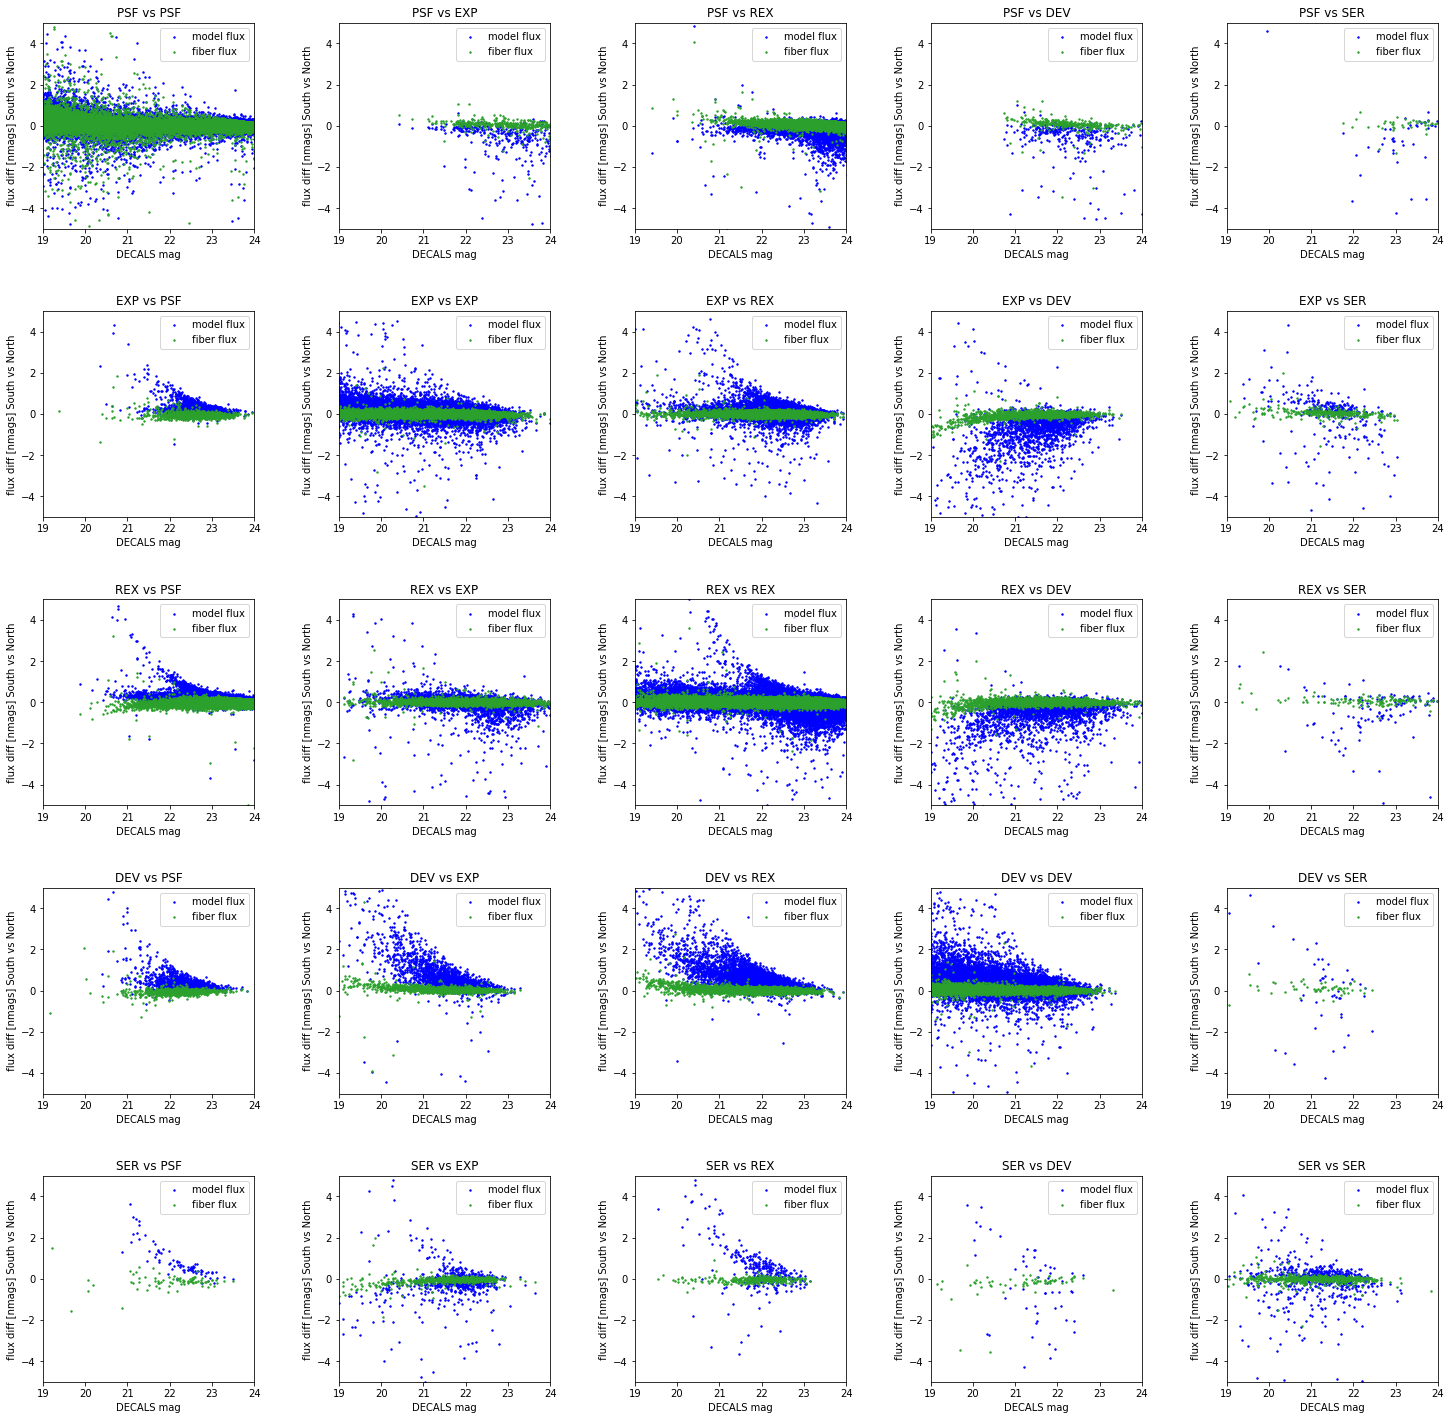

In [56]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_R'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_R'])
          
    decals_std_rflux = np.array(h5decals['FLUX_R'])
    prime_std_rflux = np.array(h5prime['FLUX_R'])
    
    fib_rflux_diff = decals_fib_rflux - prime_fib_rflux
    std_rflux_diff = decals_std_rflux - prime_std_rflux
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        istype2 = (h5decals['NOBS_G'].value.astype(int)!= 0)
        istype3 = (h5decals['NOBS_R'].value.astype(int)!= 0)
        istype4 = (h5decals['NOBS_Z'].value.astype(int)!= 0)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']): 
            istype5 = (h5prime['TYPE'].value.astype(str)== typ2)
            istype6 = (h5prime['NOBS_G'].value.astype(int)!= 0)
            istype7 = (h5prime['NOBS_R'].value.astype(int)!= 0)
            istype8 = (h5prime['NOBS_Z'].value.astype(int)!= 0)
            istype0 = istype1 & istype3 & istype4 & istype5 & istype6 & istype7 & istype8
   
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype0], std_rflux_diff[istype0], c='b', s=2)
            sub.scatter(decals_std_rmag[istype0], fib_rflux_diff[istype0], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-5, 5) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux diff [nmags] South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC1dr9-rband.png")
    plt.show()

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


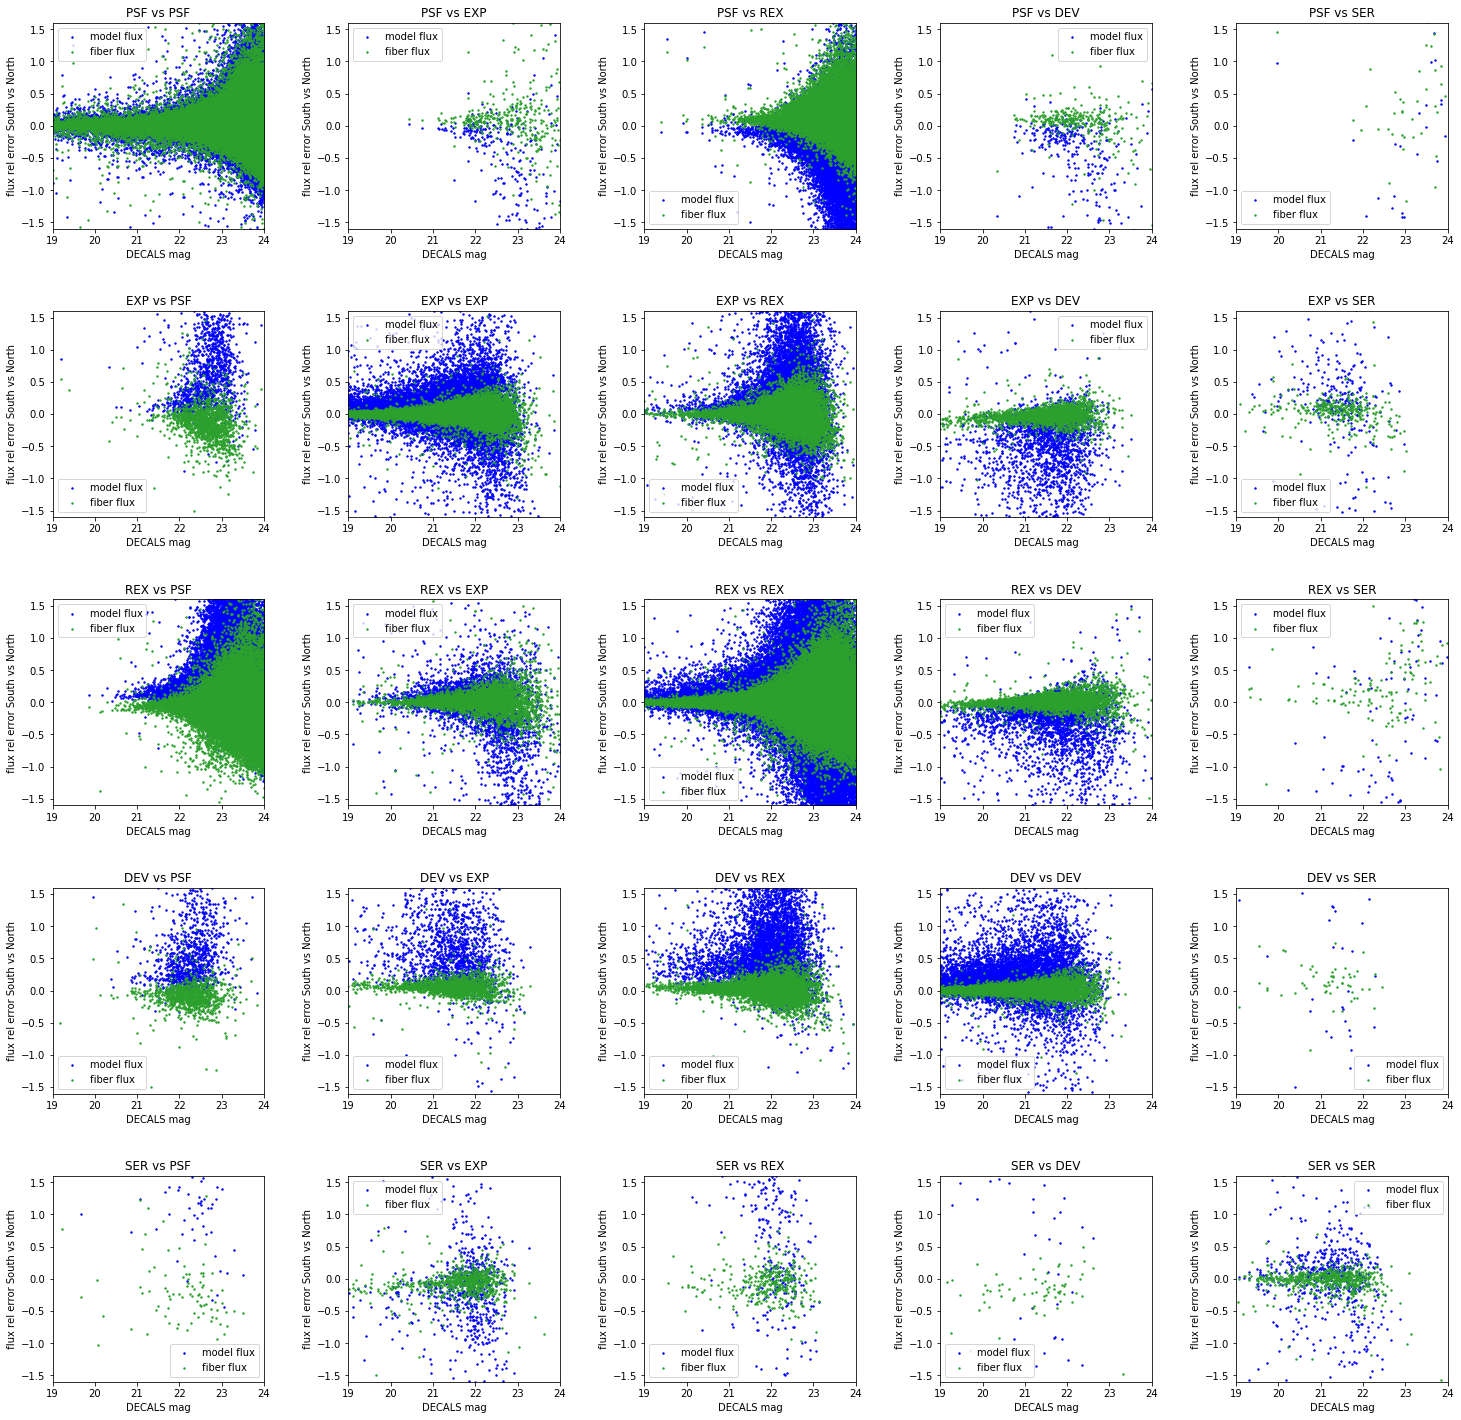

In [57]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_R'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_R'])
          
    decals_std_rflux = np.array(h5decals['FLUX_R'])
    prime_std_rflux = np.array(h5prime['FLUX_R'])
    
    fib_rflux_diff = 2.0*(decals_fib_rflux - prime_fib_rflux)/(decals_fib_rflux + prime_fib_rflux)
    std_rflux_diff = 2.0*(decals_std_rflux - prime_std_rflux)/(decals_fib_rflux + prime_fib_rflux)
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        istype2 = (h5decals['NOBS_G'].value.astype(int)!= 0)
        istype3 = (h5decals['NOBS_R'].value.astype(int)!= 0)
        istype4 = (h5decals['NOBS_Z'].value.astype(int)!= 0)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']): 
            istype5 = (h5prime['TYPE'].value.astype(str)== typ2)
            istype6 = (h5prime['NOBS_G'].value.astype(int)!= 0)
            istype7 = (h5prime['NOBS_R'].value.astype(int)!= 0)
            istype8 = (h5prime['NOBS_Z'].value.astype(int)!= 0)
            istype0 = istype1 & istype3 & istype4 & istype5 & istype6 & istype7 & istype8

            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype0], std_rflux_diff[istype0], c='b', s=2)
            sub.scatter(decals_std_rmag[istype0], fib_rflux_diff[istype0], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-1.6, 1.6) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux rel error South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC2dr9-rband.png")
    plt.show()

## G-BAND

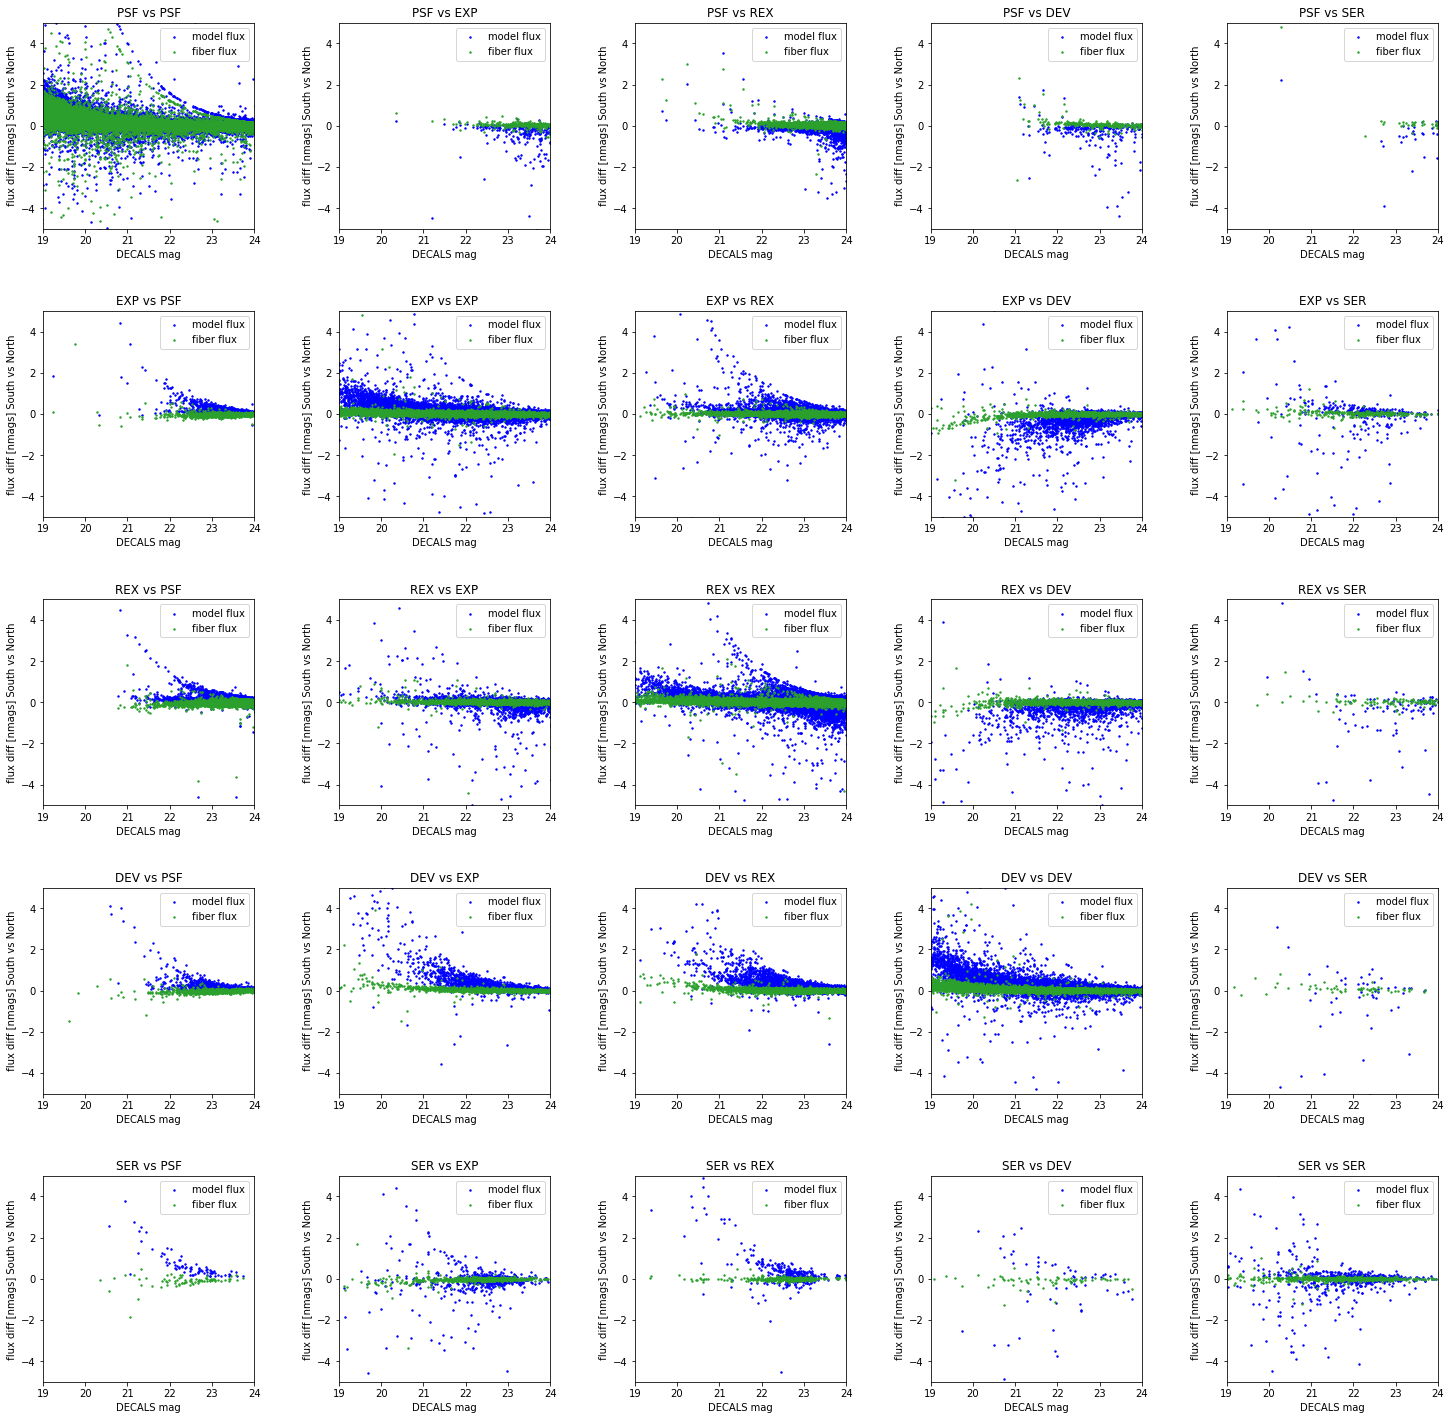

In [54]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_G'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_G'])
          
    decals_std_rflux = np.array(h5decals['FLUX_G'])
    prime_std_rflux = np.array(h5prime['FLUX_G'])
    
    fib_rflux_diff = decals_fib_rflux - prime_fib_rflux
    std_rflux_diff = decals_std_rflux - prime_std_rflux
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        istype2 = (h5decals['NOBS_G'].value.astype(int)!= 0)
        istype3 = (h5decals['NOBS_R'].value.astype(int)!= 0)
        istype4 = (h5decals['NOBS_Z'].value.astype(int)!= 0)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']): 
            istype5 = (h5prime['TYPE'].value.astype(str)== typ2)
            istype6 = (h5prime['NOBS_G'].value.astype(int)!= 0)
            istype7 = (h5prime['NOBS_R'].value.astype(int)!= 0)
            istype8 = (h5prime['NOBS_Z'].value.astype(int)!= 0)
            istype0 = istype1 & istype3 & istype4 & istype5 & istype6 & istype7 & istype8
   
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype0], std_rflux_diff[istype0], c='b', s=2)
            sub.scatter(decals_std_rmag[istype0], fib_rflux_diff[istype0], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-5, 5) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux diff [nmags] South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC1dr9-gband.png")
    plt.show()

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


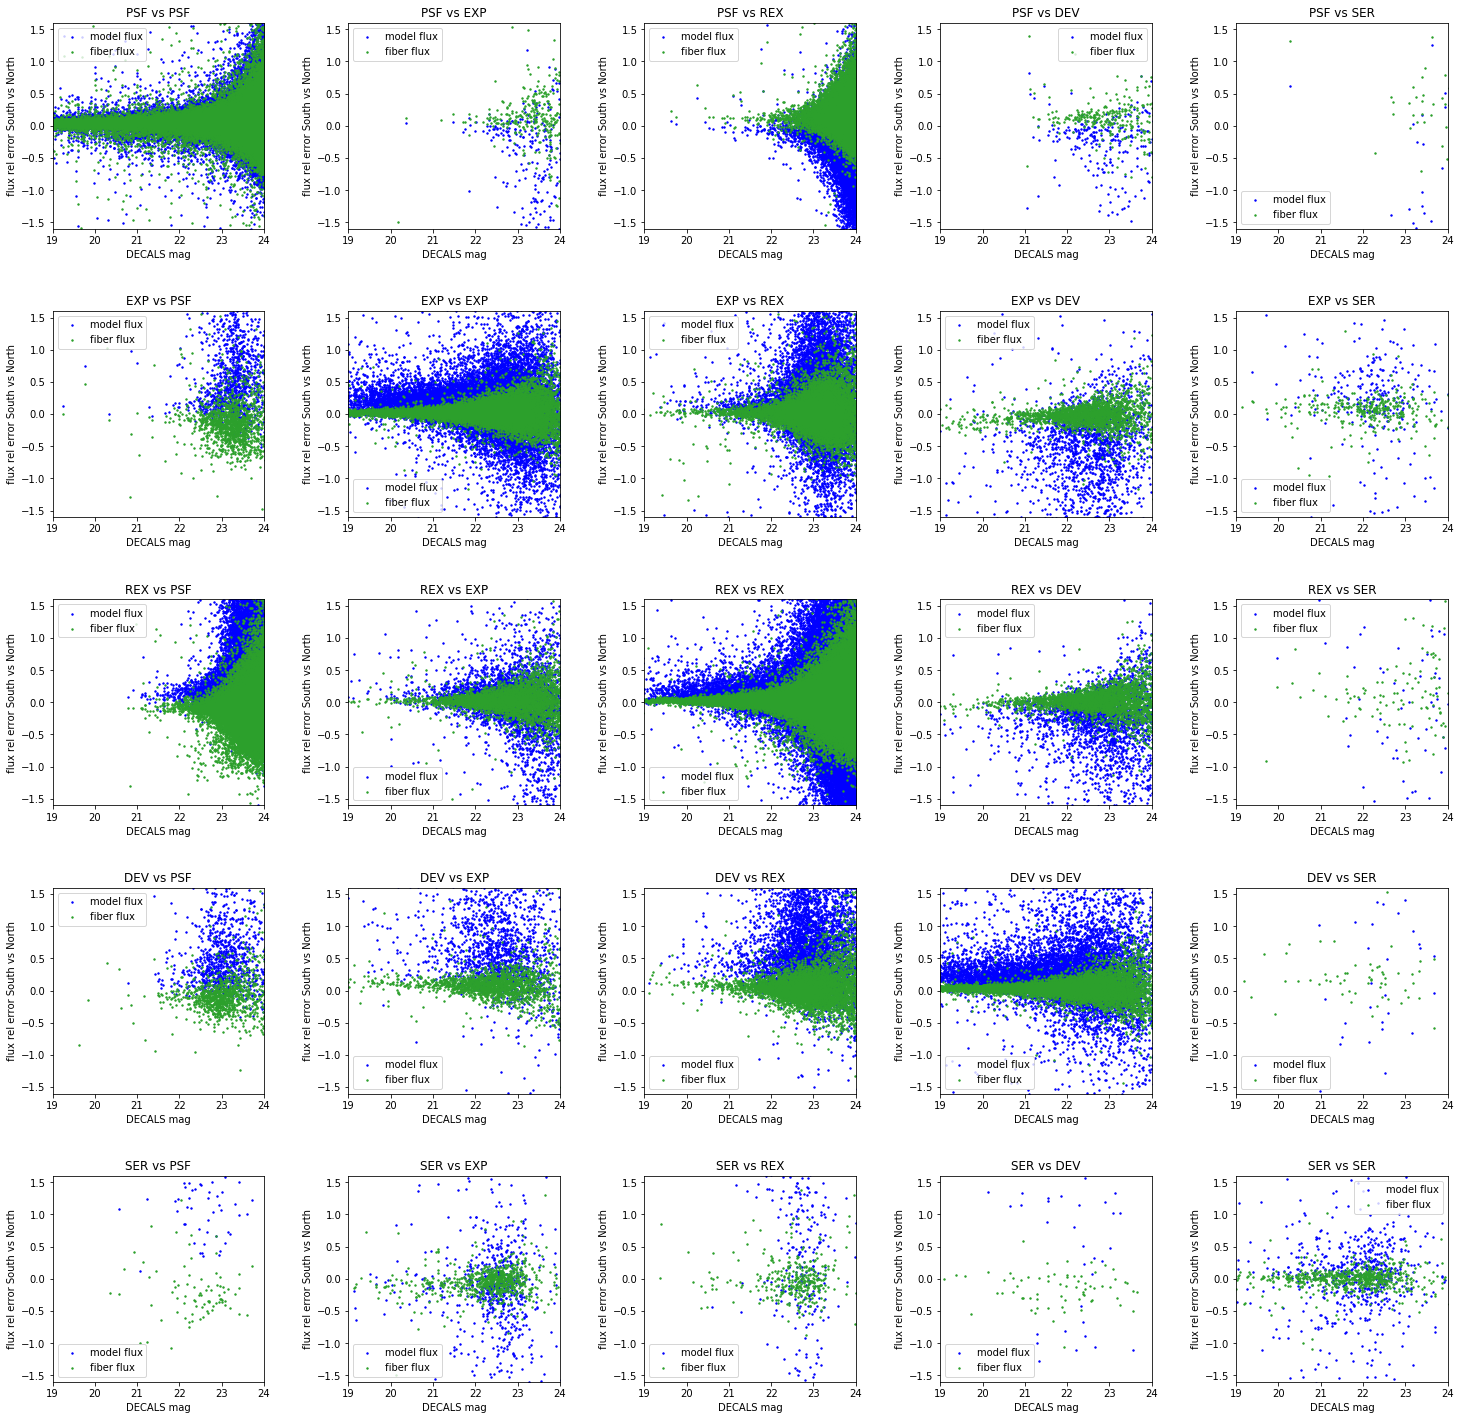

In [55]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_G'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_G'])
          
    decals_std_rflux = np.array(h5decals['FLUX_G'])
    prime_std_rflux = np.array(h5prime['FLUX_G'])
    
    fib_rflux_diff = 2.0*(decals_fib_rflux - prime_fib_rflux)/(decals_fib_rflux + prime_fib_rflux)
    std_rflux_diff = 2.0*(decals_std_rflux - prime_std_rflux)/(decals_fib_rflux + prime_fib_rflux)
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        istype2 = (h5decals['NOBS_G'].value.astype(int)!= 0)
        istype3 = (h5decals['NOBS_R'].value.astype(int)!= 0)
        istype4 = (h5decals['NOBS_Z'].value.astype(int)!= 0)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']): 
            istype5 = (h5prime['TYPE'].value.astype(str)== typ2)
            istype6 = (h5prime['NOBS_G'].value.astype(int)!= 0)
            istype7 = (h5prime['NOBS_R'].value.astype(int)!= 0)
            istype8 = (h5prime['NOBS_Z'].value.astype(int)!= 0)
            istype0 = istype1 & istype3 & istype4 & istype5 & istype6 & istype7 & istype8
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype0], std_rflux_diff[istype0], c='b', s=2)
            sub.scatter(decals_std_rmag[istype0], fib_rflux_diff[istype0], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-1.6, 1.6) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux rel error South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC2dr9-gband.png")
    plt.show()

## Z-BAND

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in arcsinh
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in arcsinh


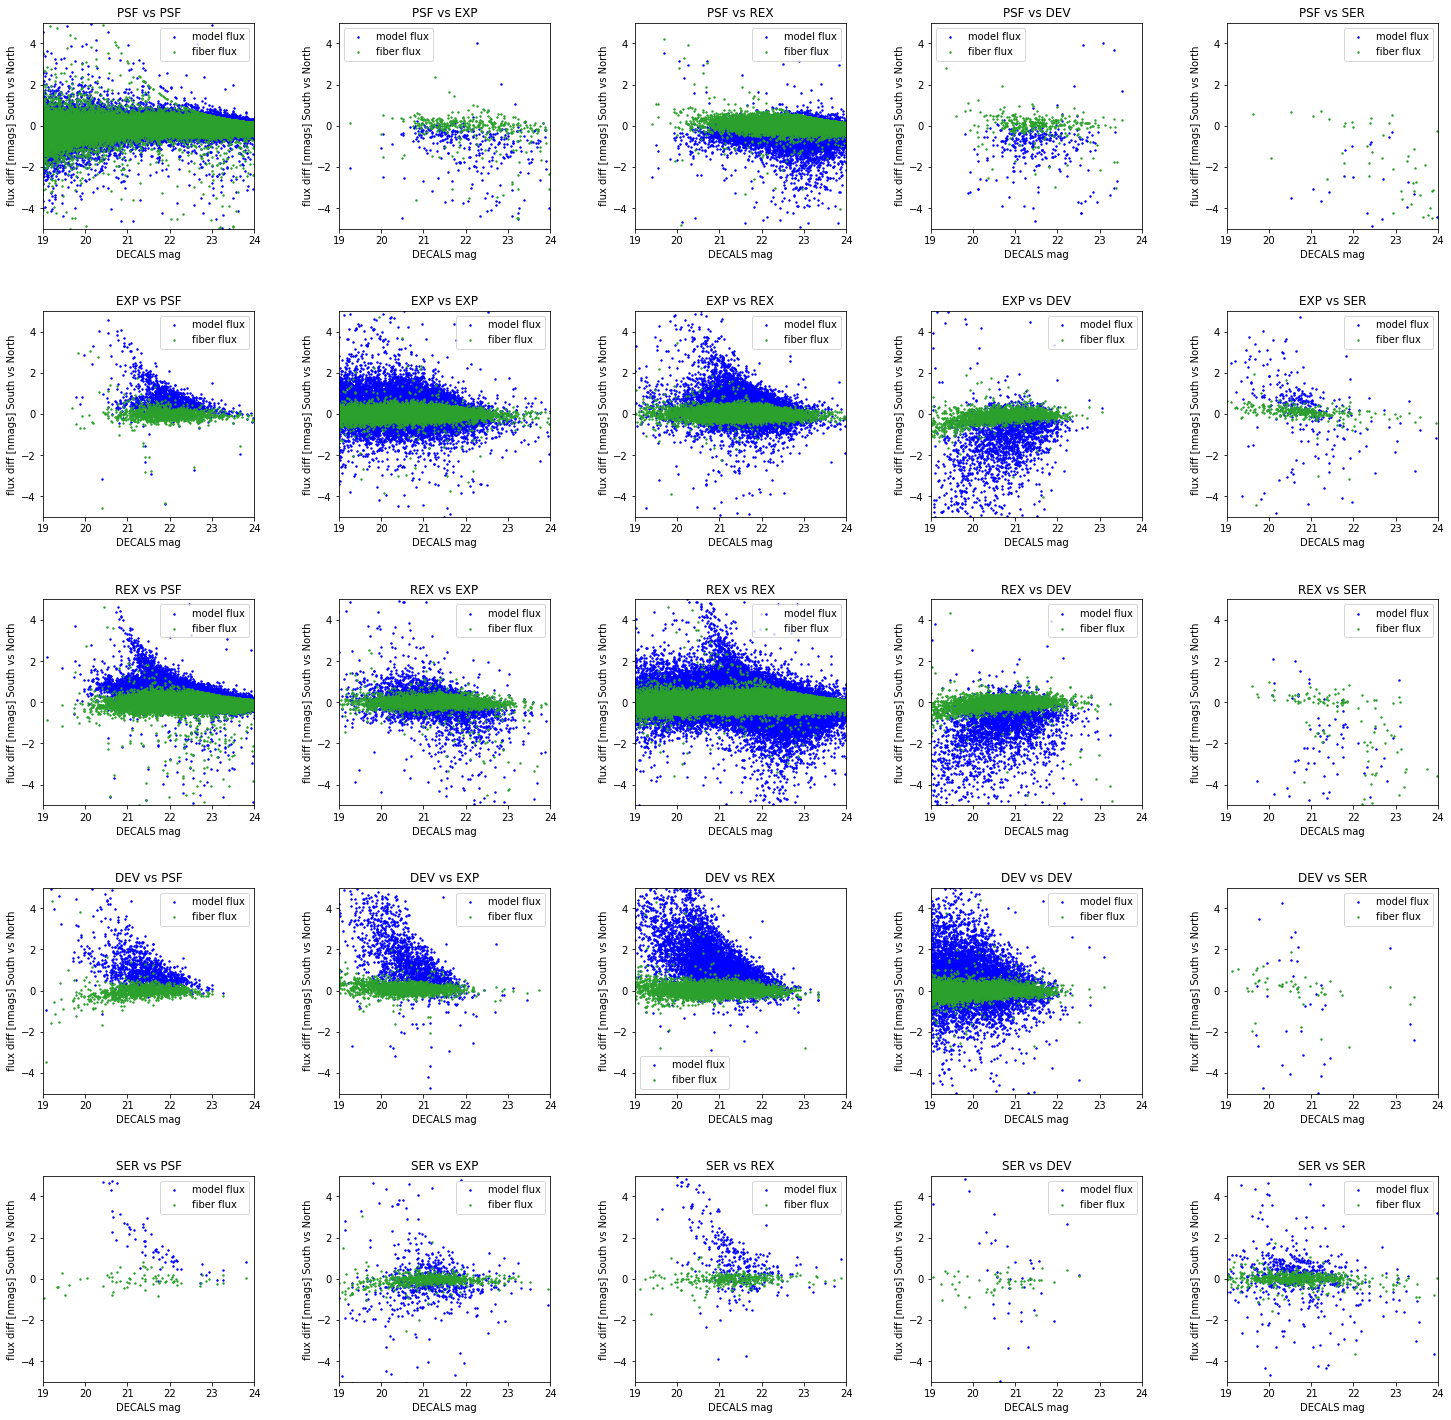

In [51]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_Z'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_Z'])
          
    decals_std_rflux = np.array(h5decals['FLUX_Z'])
    prime_std_rflux = np.array(h5prime['FLUX_Z'])
    
    fib_rflux_diff = decals_fib_rflux - prime_fib_rflux
    std_rflux_diff = decals_std_rflux - prime_std_rflux
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        istype2 = (h5decals['NOBS_G'].value.astype(int)!= 0)
        istype3 = (h5decals['NOBS_R'].value.astype(int)!= 0)
        istype4 = (h5decals['NOBS_Z'].value.astype(int)!= 0)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']): 
            istype5 = (h5prime['TYPE'].value.astype(str)== typ2)
            istype6 = (h5prime['NOBS_G'].value.astype(int)!= 0)
            istype7 = (h5prime['NOBS_R'].value.astype(int)!= 0)
            istype8 = (h5prime['NOBS_Z'].value.astype(int)!= 0)
            istype0 = istype1 & istype3 & istype4 & istype5 & istype6 & istype7 & istype8
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype0], std_rflux_diff[istype0], c='b', s=2)
            sub.scatter(decals_std_rmag[istype0], fib_rflux_diff[istype0], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-5, 5) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux diff [nmags] South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC1dr9-zband.png")
    plt.show()

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in arcsinh
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykerne

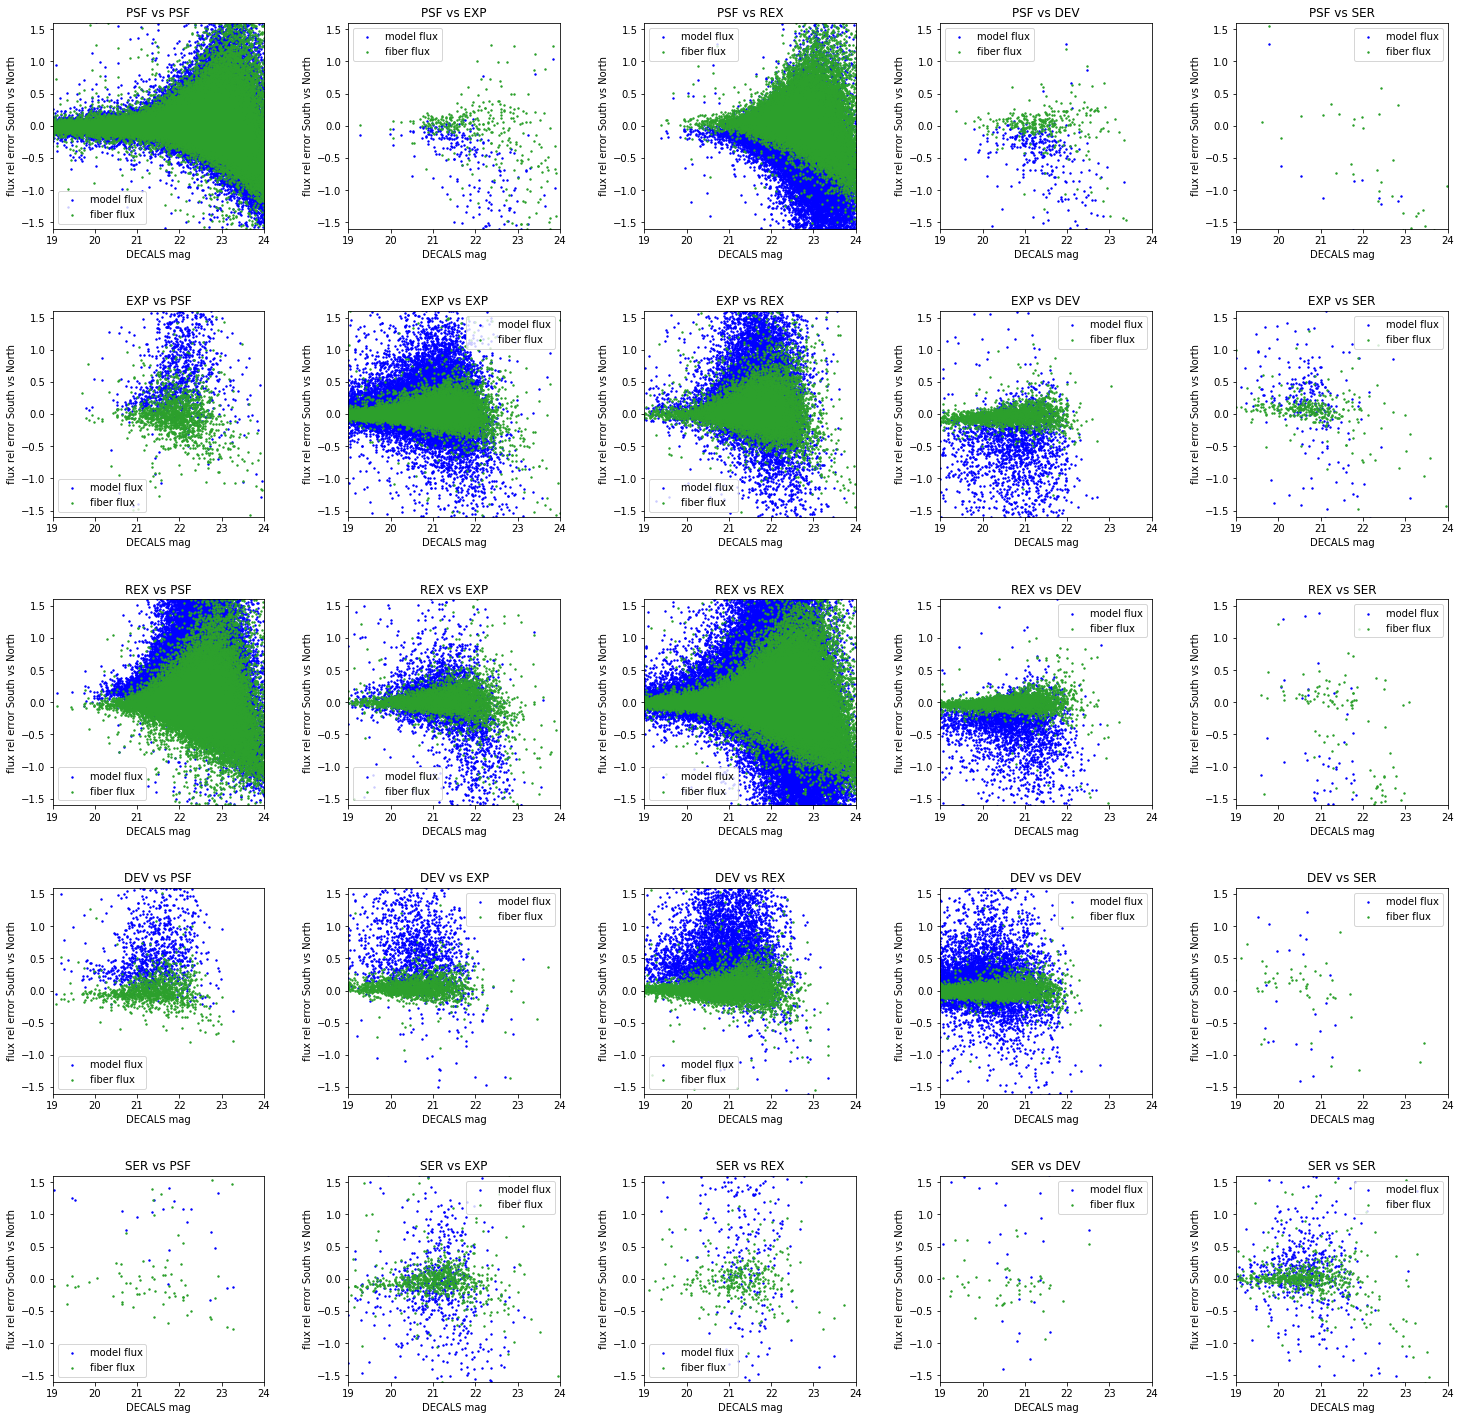

In [50]:
    decals_fib_rflux = np.array(h5decals['FIBERFLUX_Z'])
    prime_fib_rflux = np.array(h5prime['FIBERFLUX_Z'])
          
    decals_std_rflux = np.array(h5decals['FLUX_Z'])
    prime_std_rflux = np.array(h5prime['FLUX_Z'])
    
    fib_rflux_diff = 2.0*(decals_fib_rflux - prime_fib_rflux)/(decals_fib_rflux + prime_fib_rflux)
    std_rflux_diff = 2.0*(decals_std_rflux - prime_std_rflux)/(decals_fib_rflux + prime_fib_rflux)
    
    decals_std_rmag = flux2mag(decals_std_rflux,band='r',method='asinh')
    
    
    fig = plt.figure(figsize=(25,25))
    isub=0
    for i1, typ1 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']):
        istype1 = (h5decals['TYPE'].value.astype(str) == typ1)
        istype2 = (h5decals['NOBS_G'].value.astype(int)!= 0)
        istype3 = (h5decals['NOBS_R'].value.astype(int)!= 0)
        istype4 = (h5decals['NOBS_Z'].value.astype(int)!= 0)
        for i2, typ2 in enumerate(['PSF', 'EXP', 'REX', 'DEV', 'SER']): 
            istype5 = (h5prime['TYPE'].value.astype(str)== typ2)
            istype6 = (h5prime['NOBS_G'].value.astype(int)!= 0)
            istype7 = (h5prime['NOBS_R'].value.astype(int)!= 0)
            istype8 = (h5prime['NOBS_Z'].value.astype(int)!= 0)
            istype0 = istype1 & istype3 & istype4 & istype5 & istype6 & istype7 & istype8
            
            #print(np.sum(istype2))
            sub = fig.add_subplot(5,5,isub+1)
            isub = isub + 1 
             
            sub.scatter(decals_std_rmag[istype0], std_rflux_diff[istype0], c='b', s=2)
            sub.scatter(decals_std_rmag[istype0], fib_rflux_diff[istype0], c='C2', s=2)

            #mytitle = 'decals '+ typ1 +'  90Prime+mosaic '+typ2
            mytitle = typ1+ ' vs ' + typ2
            sub.set_xlim(19, 24) 
            sub.set_ylim(-1.6, 1.6) 
            sub.set_xlabel('DECALS mag')
            sub.set_ylabel(' flux rel error South vs North ')
            sub.set_title(mytitle)
            sub.legend(["model flux","fiber flux"])
            
    fig.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.savefig("NorthSouthComparisonC2dr9-zband.png")
    plt.show()